## Einleitung

Dieses Notebook erstellt publikationsreife Grafiken für PRECISION-Berichte.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')

# PRECISION Corporate Design
PRECISION_PALETTE = {
    'primary': '#1a365d',
    'secondary': '#2c5282', 
    'accent': '#3182ce',
    'success': '#38a169',
    'warning': '#d69e2e',
    'danger': '#e53e3e',
    'light': '#f7fafc',
    'dark': '#1a202c'
}

# Matplotlib Style konfigurieren
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (12, 7),
    'figure.dpi': 150,
    'font.family': 'sans-serif',
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': True,
    'legend.framealpha': 0.9
})

# Seaborn Palette setzen
precision_colors = [PRECISION_PALETTE['primary'], PRECISION_PALETTE['accent'], 
                    PRECISION_PALETTE['secondary'], PRECISION_PALETTE['success']]
sns.set_palette(precision_colors)

print('PRECISION Visualisierungs-Setup geladen!')

PRECISION Visualisierungs-Setup geladen!


In [2]:
# Daten laden
df = pd.read_csv('../data/sample/patient_data.csv')
print(f'Daten geladen: {len(df)} Patienten')

Daten geladen: 20 Patienten


## 1. Demografische Übersicht

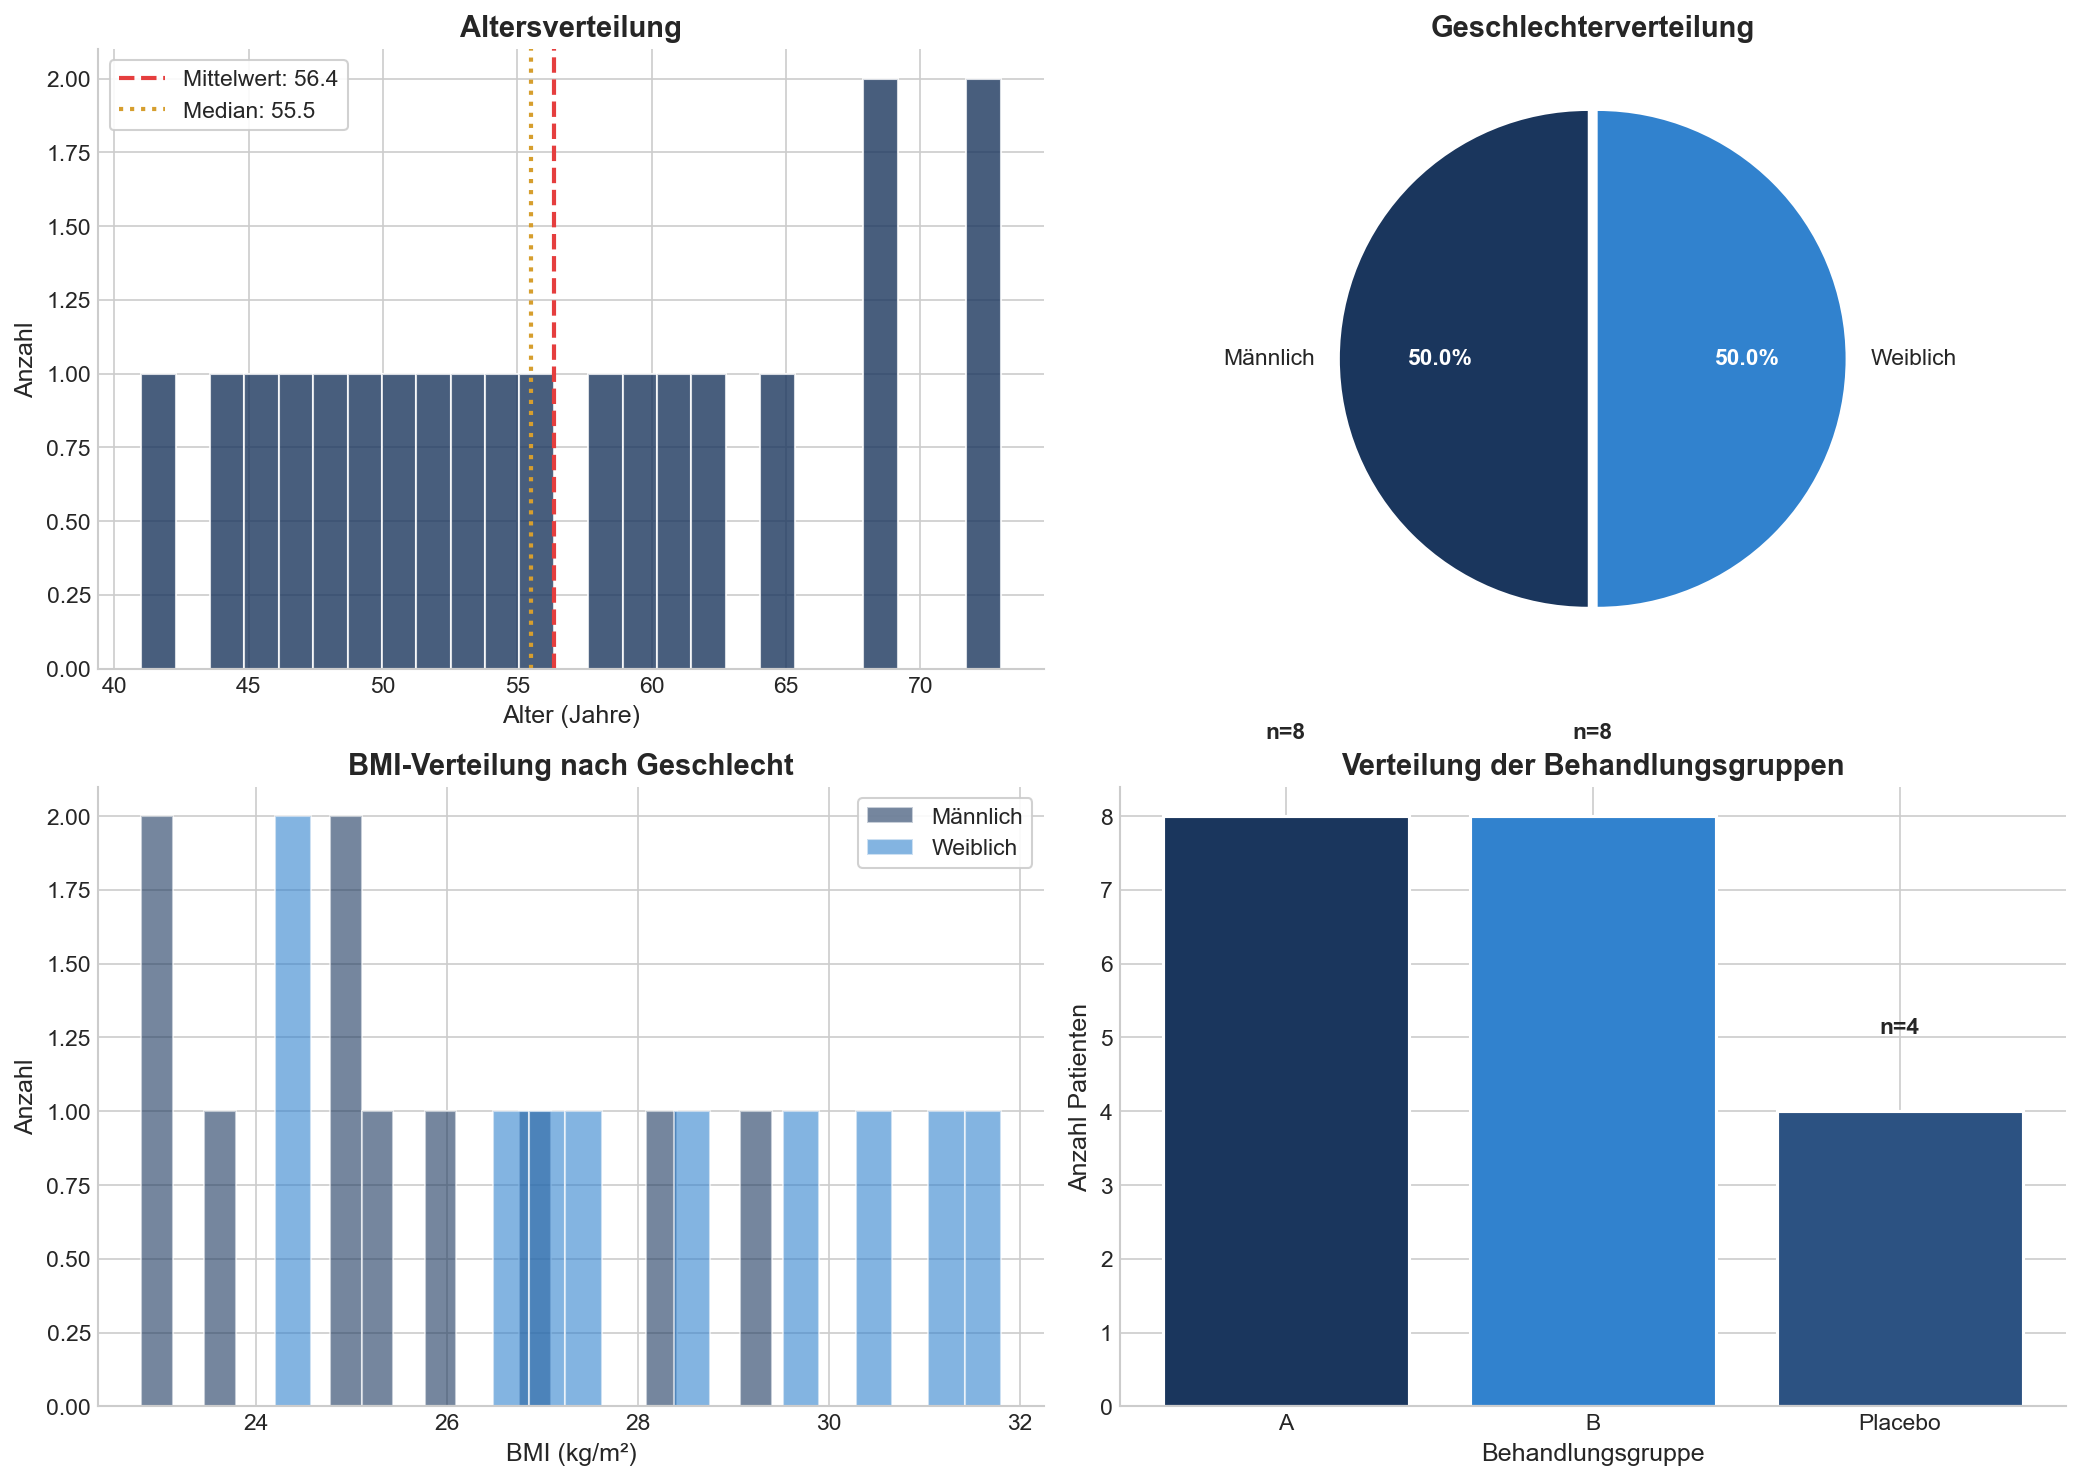

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Altersverteilung
ax1 = axes[0, 0]
ax1.hist(df['age'], bins=25, color=PRECISION_PALETTE['primary'], alpha=0.8, edgecolor='white')
ax1.axvline(df['age'].mean(), color=PRECISION_PALETTE['danger'], linestyle='--', linewidth=2, label=f'Mittelwert: {df["age"].mean():.1f}')
ax1.axvline(df['age'].median(), color=PRECISION_PALETTE['warning'], linestyle=':', linewidth=2, label=f'Median: {df["age"].median():.1f}')
ax1.set_xlabel('Alter (Jahre)')
ax1.set_ylabel('Anzahl')
ax1.set_title('Altersverteilung')
ax1.legend()

# 2. Geschlechterverteilung
ax2 = axes[0, 1]
gender_counts = df['gender'].value_counts()
colors_pie = [PRECISION_PALETTE['primary'], PRECISION_PALETTE['accent']]
wedges, texts, autotexts = ax2.pie(gender_counts.values, labels=['Männlich', 'Weiblich'], 
                                    autopct='%1.1f%%', colors=colors_pie, startangle=90,
                                    explode=(0.02, 0.02), shadow=False)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title('Geschlechterverteilung')

# 3. BMI-Verteilung nach Geschlecht
ax3 = axes[1, 0]
for gender, color, label in [('M', PRECISION_PALETTE['primary'], 'Männlich'), 
                              ('F', PRECISION_PALETTE['accent'], 'Weiblich')]:
    subset = df[df['gender'] == gender]
    ax3.hist(subset['bmi'], bins=20, alpha=0.6, color=color, label=label, edgecolor='white')
ax3.set_xlabel('BMI (kg/m²)')
ax3.set_ylabel('Anzahl')
ax3.set_title('BMI-Verteilung nach Geschlecht')
ax3.legend()

# 4. Behandlungsgruppen
ax4 = axes[1, 1]
group_counts = df['treatment_group'].value_counts().sort_index()
bars = ax4.bar(group_counts.index, group_counts.values, 
               color=[PRECISION_PALETTE['primary'], PRECISION_PALETTE['accent'], PRECISION_PALETTE['secondary']],
               edgecolor='white', linewidth=1.5)
ax4.set_xlabel('Behandlungsgruppe')
ax4.set_ylabel('Anzahl Patienten')
ax4.set_title('Verteilung der Behandlungsgruppen')

# Werte auf Balken
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'n={int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../assets/images/demographics_overview.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## 2. Klinische Parameter

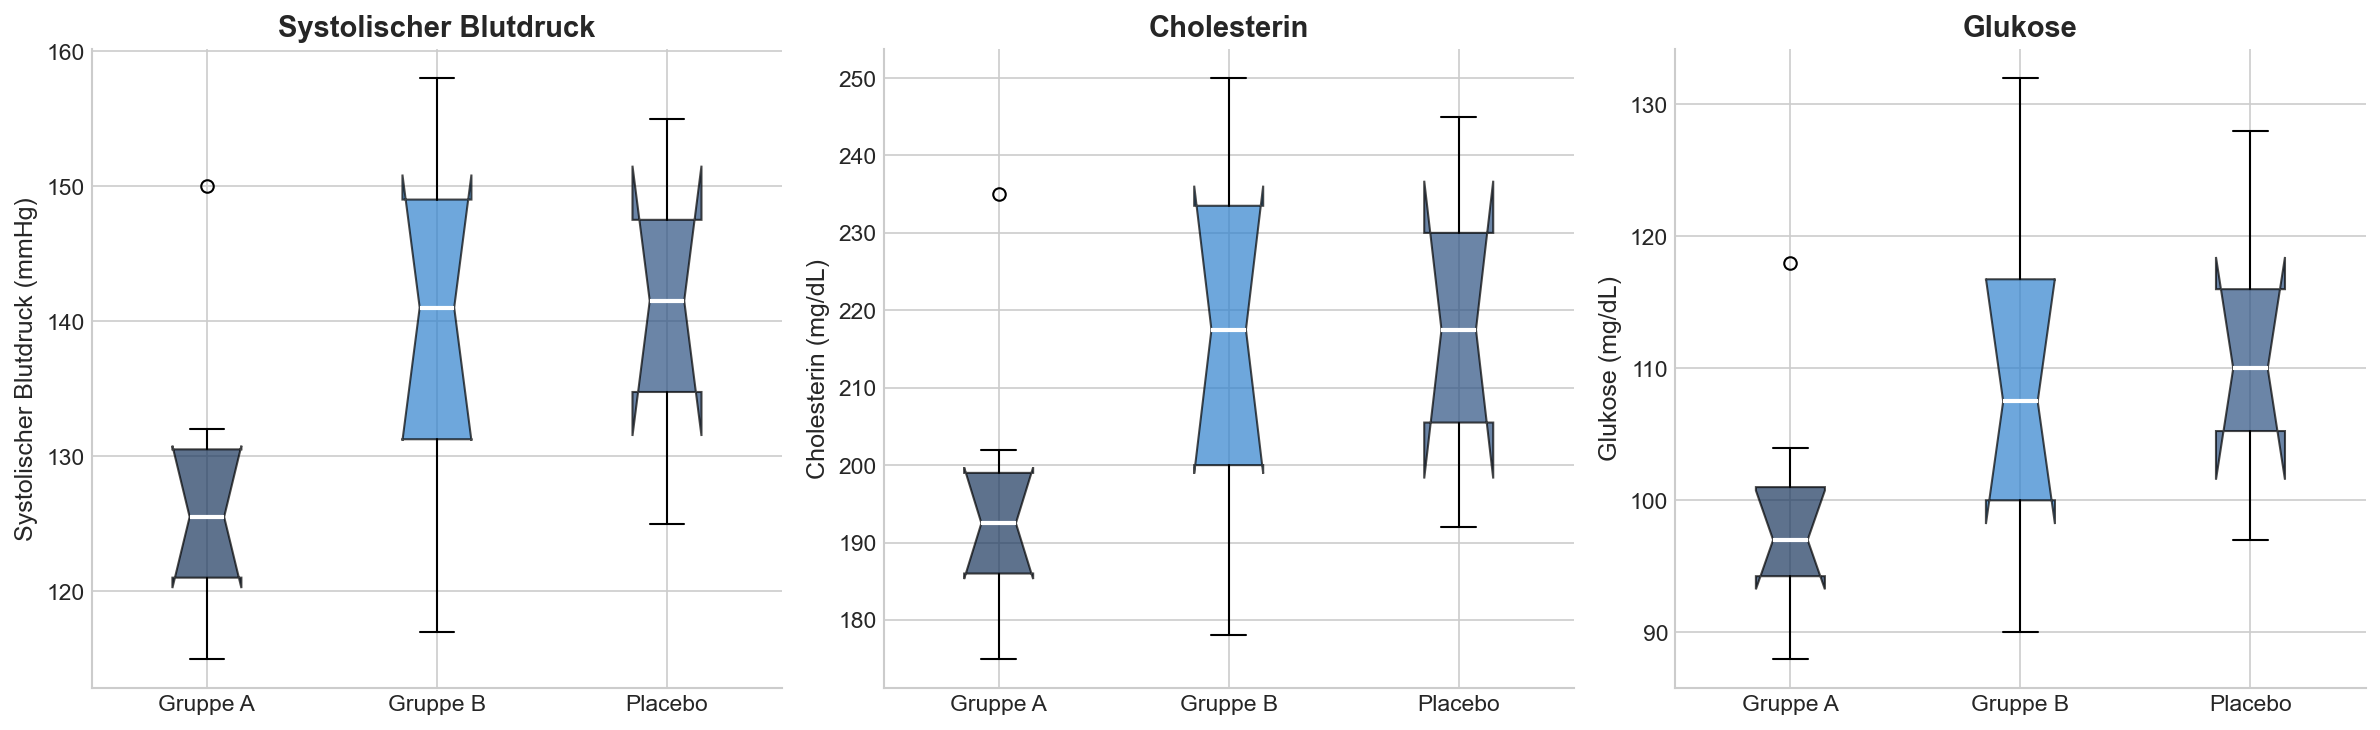

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Boxplots für klinische Parameter nach Behandlungsgruppe
clinical_vars = ['blood_pressure_sys', 'cholesterol', 'glucose']
titles = ['Systolischer Blutdruck', 'Cholesterin', 'Glukose']
units = ['mmHg', 'mg/dL', 'mg/dL']

for ax, var, title, unit in zip(axes, clinical_vars, titles, units):
    bp = ax.boxplot([df[df['treatment_group'] == g][var] for g in ['A', 'B', 'Placebo']],
                    labels=['Gruppe A', 'Gruppe B', 'Placebo'],
                    patch_artist=True, notch=True)
    
    colors_box = [PRECISION_PALETTE['primary'], PRECISION_PALETTE['accent'], PRECISION_PALETTE['secondary']]
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    for median in bp['medians']:
        median.set_color('white')
        median.set_linewidth(2)
    
    ax.set_ylabel(f'{title} ({unit})')
    ax.set_title(title)

plt.tight_layout()
plt.savefig('../assets/images/clinical_parameters.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## 3. Response-Analyse

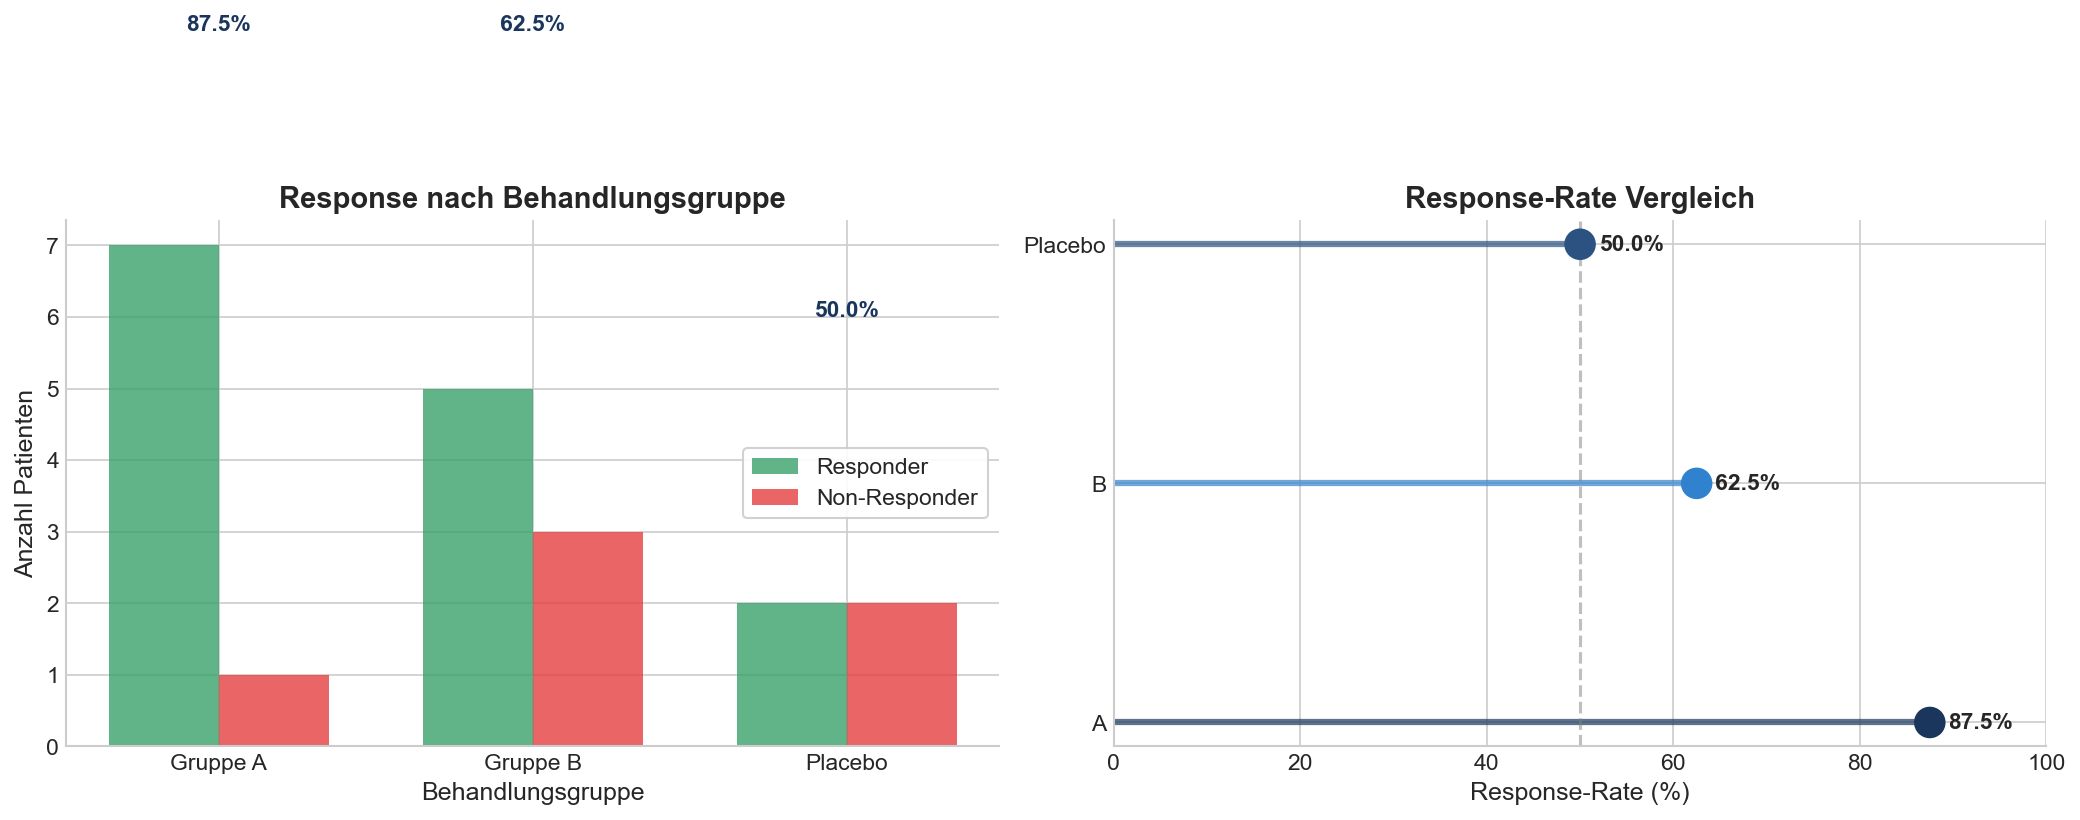

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Response-Rate nach Behandlungsgruppe
ax1 = axes[0]
response_by_group = df.groupby('treatment_group')['response'].agg(['sum', 'count'])
response_by_group['non_response'] = response_by_group['count'] - response_by_group['sum']
response_by_group['rate'] = response_by_group['sum'] / response_by_group['count'] * 100

x = np.arange(len(response_by_group))
width = 0.35

bars1 = ax1.bar(x - width/2, response_by_group['sum'], width, label='Responder', 
                color=PRECISION_PALETTE['success'], alpha=0.8)
bars2 = ax1.bar(x + width/2, response_by_group['non_response'], width, label='Non-Responder',
                color=PRECISION_PALETTE['danger'], alpha=0.8)

ax1.set_xlabel('Behandlungsgruppe')
ax1.set_ylabel('Anzahl Patienten')
ax1.set_title('Response nach Behandlungsgruppe')
ax1.set_xticks(x)
ax1.set_xticklabels(['Gruppe A', 'Gruppe B', 'Placebo'])
ax1.legend()

# Response-Rate als Text
for i, (idx, row) in enumerate(response_by_group.iterrows()):
    ax1.text(i, row['count'] + 2, f'{row["rate"]:.1f}%', ha='center', fontweight='bold',
             color=PRECISION_PALETTE['primary'])

# 2. Response-Rate Vergleich (Lollipop Chart)
ax2 = axes[1]
groups = response_by_group.index.tolist()
rates = response_by_group['rate'].values
colors_lollipop = [PRECISION_PALETTE['primary'], PRECISION_PALETTE['accent'], PRECISION_PALETTE['secondary']]

ax2.hlines(y=groups, xmin=0, xmax=rates, color=colors_lollipop, alpha=0.7, linewidth=3)
ax2.scatter(rates, groups, color=colors_lollipop, s=200, zorder=3)

for i, (g, r) in enumerate(zip(groups, rates)):
    ax2.text(r + 2, i, f'{r:.1f}%', va='center', fontweight='bold')

ax2.set_xlabel('Response-Rate (%)')
ax2.set_xlim(0, 100)
ax2.set_title('Response-Rate Vergleich')
ax2.axvline(x=50, color='gray', linestyle='--', alpha=0.5, label='50% Referenz')

plt.tight_layout()
plt.savefig('../assets/images/response_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## 4. Zusammenfassende Infografik

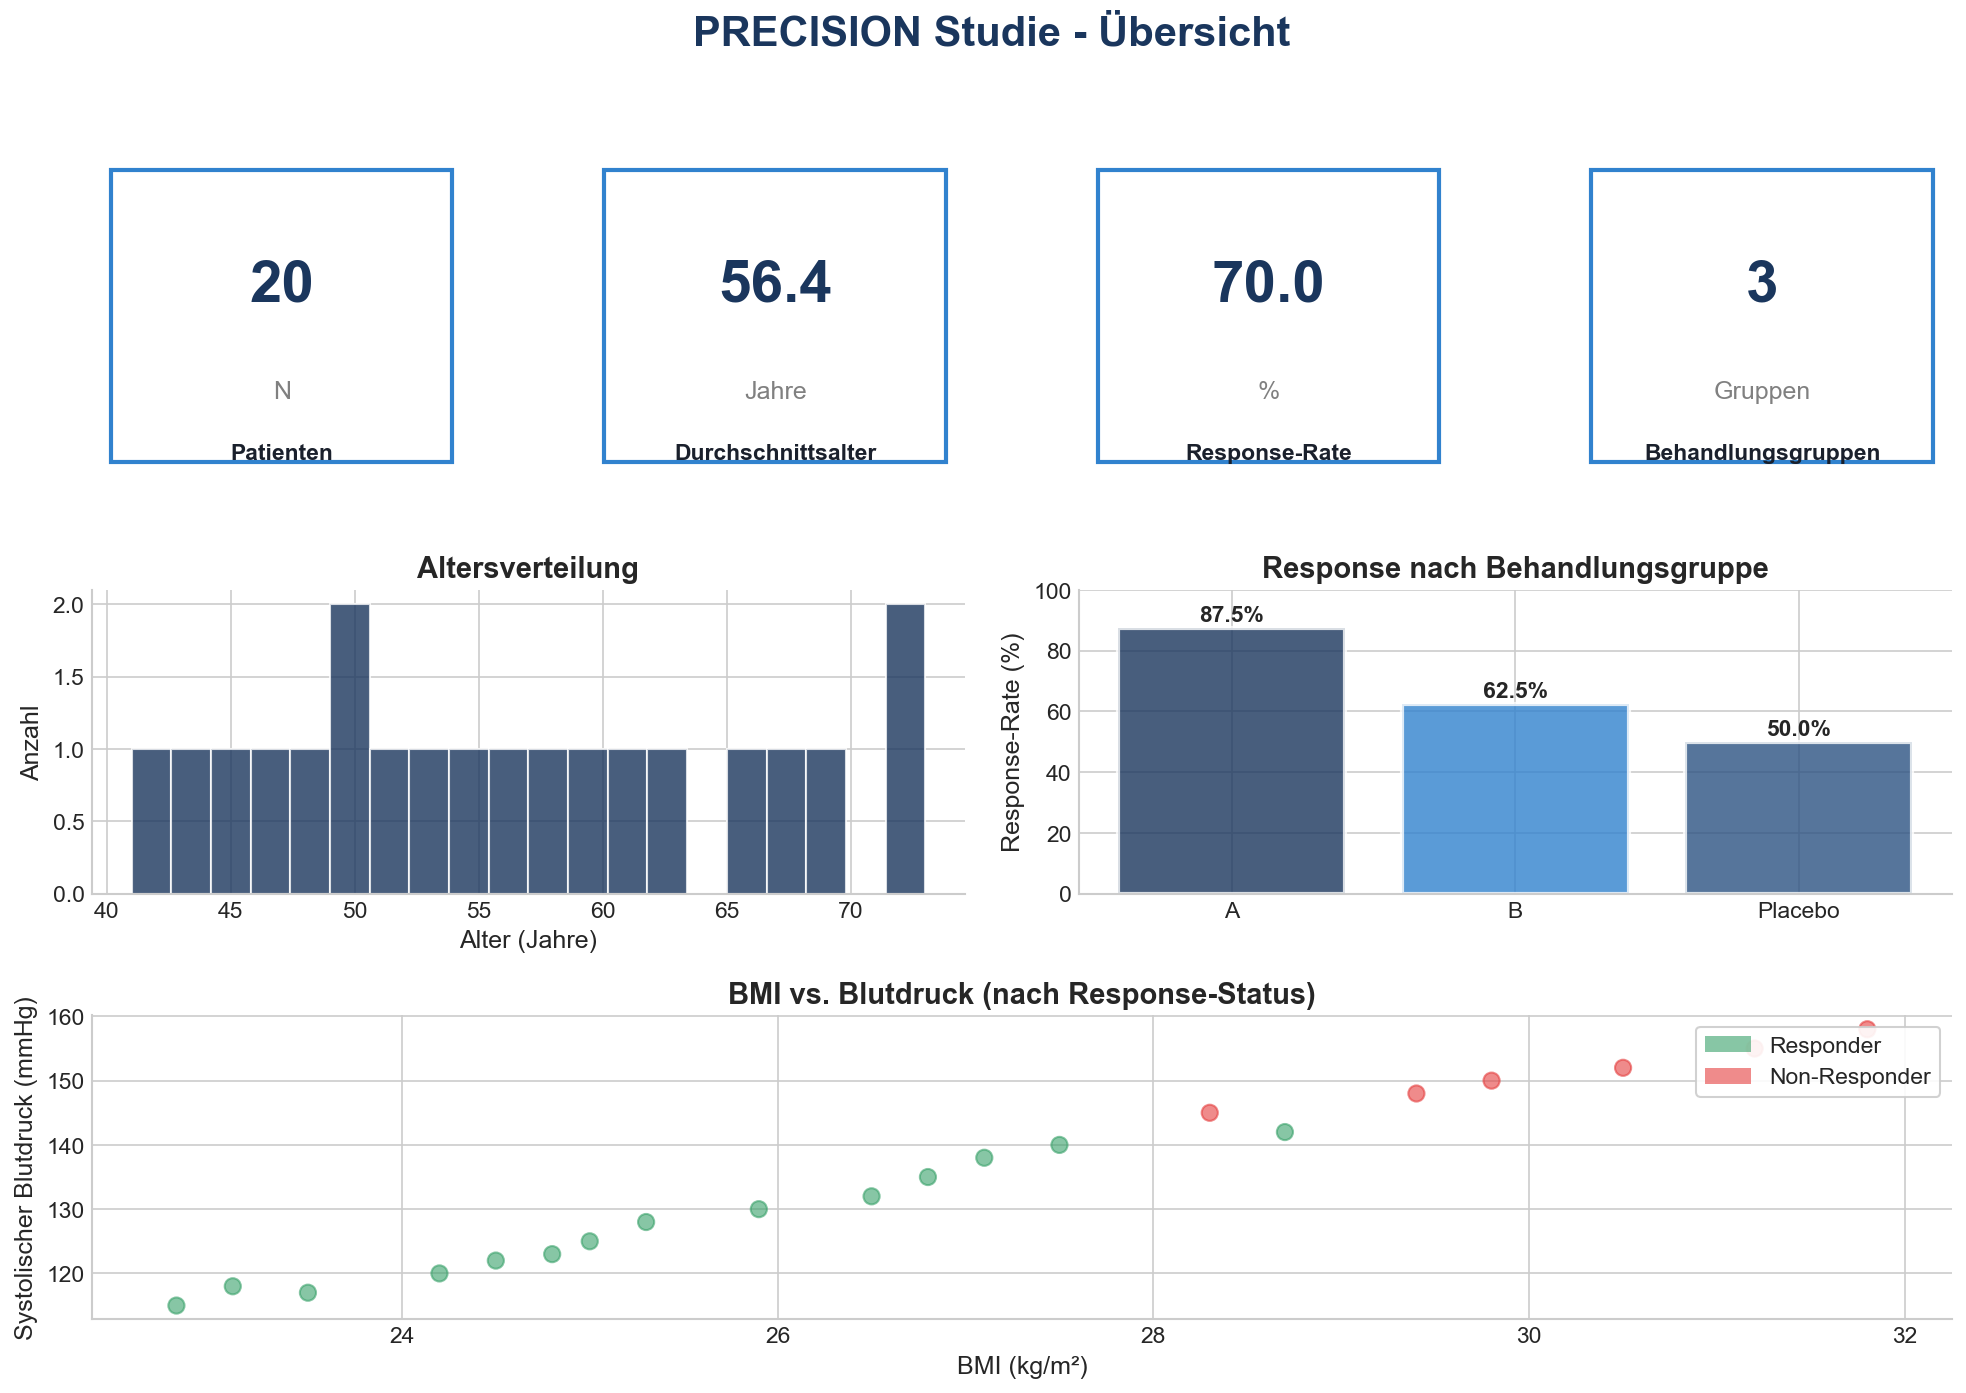

In [6]:
fig = plt.figure(figsize=(16, 10))

# Hintergrund
fig.patch.set_facecolor('white')

# Titel
fig.suptitle('PRECISION Studie - Übersicht', fontsize=20, fontweight='bold', 
             color=PRECISION_PALETTE['primary'], y=0.98)

# Grid für Subplots
gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.3)

# Key Metrics (obere Reihe)
metrics = [
    ('Patienten', len(df), 'N'),
    ('Durchschnittsalter', f"{df['age'].mean():.1f}", 'Jahre'),
    ('Response-Rate', f"{df['response'].mean()*100:.1f}", '%'),
    ('Behandlungsgruppen', '3', 'Gruppen')
]

for i, (label, value, unit) in enumerate(metrics):
    ax = fig.add_subplot(gs[0, i])
    ax.text(0.5, 0.6, str(value), fontsize=28, fontweight='bold', 
            color=PRECISION_PALETTE['primary'], ha='center', va='center', transform=ax.transAxes)
    ax.text(0.5, 0.25, unit, fontsize=12, color='gray', ha='center', va='center', transform=ax.transAxes)
    ax.text(0.5, 0.05, label, fontsize=11, fontweight='bold', 
            color=PRECISION_PALETTE['dark'], ha='center', va='center', transform=ax.transAxes)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    # Box um Metric
    rect = plt.Rectangle((0.05, 0.02), 0.9, 0.96, fill=False, 
                          edgecolor=PRECISION_PALETTE['accent'], linewidth=2, 
                          transform=ax.transAxes, clip_on=False)
    ax.add_patch(rect)

# Altersverteilung (Mitte links)
ax_age = fig.add_subplot(gs[1, :2])
ax_age.hist(df['age'], bins=20, color=PRECISION_PALETTE['primary'], alpha=0.8, edgecolor='white')
ax_age.set_xlabel('Alter (Jahre)')
ax_age.set_ylabel('Anzahl')
ax_age.set_title('Altersverteilung', fontweight='bold')

# Response nach Gruppe (Mitte rechts)
ax_response = fig.add_subplot(gs[1, 2:])
response_rates = df.groupby('treatment_group')['response'].mean() * 100
bars = ax_response.bar(response_rates.index, response_rates.values,
                       color=[PRECISION_PALETTE['primary'], PRECISION_PALETTE['accent'], PRECISION_PALETTE['secondary']],
                       alpha=0.8, edgecolor='white', linewidth=2)
ax_response.set_ylabel('Response-Rate (%)')
ax_response.set_title('Response nach Behandlungsgruppe', fontweight='bold')
ax_response.set_ylim(0, 100)
for bar in bars:
    height = bar.get_height()
    ax_response.text(bar.get_x() + bar.get_width()/2., height + 2,
                     f'{height:.1f}%', ha='center', fontweight='bold')

# Scatter: BMI vs Blutdruck (unten)
ax_scatter = fig.add_subplot(gs[2, :])
colors_scatter = df['response'].map({0: PRECISION_PALETTE['danger'], 1: PRECISION_PALETTE['success']})
ax_scatter.scatter(df['bmi'], df['blood_pressure_sys'], c=colors_scatter, alpha=0.6, s=60)
ax_scatter.set_xlabel('BMI (kg/m²)')
ax_scatter.set_ylabel('Systolischer Blutdruck (mmHg)')
ax_scatter.set_title('BMI vs. Blutdruck (nach Response-Status)', fontweight='bold')

# Custom Legend
legend_elements = [
    Patch(facecolor=PRECISION_PALETTE['success'], alpha=0.6, label='Responder'),
    Patch(facecolor=PRECISION_PALETTE['danger'], alpha=0.6, label='Non-Responder')
]
ax_scatter.legend(handles=legend_elements, loc='upper right')

plt.savefig('../assets/images/study_overview.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## 5. Export-Informationen

Alle Grafiken wurden gespeichert in `assets/images/`:

- `demographics_overview.png` - Demografische Übersicht
- `clinical_parameters.png` - Klinische Parameter
- `response_analysis.png` - Response-Analyse
- `study_overview.png` - Zusammenfassende Infografik

Diese können direkt in Quarto-Dokumenten verwendet werden.